# scraping

In [1]:
import pandas as pd

In [2]:
import requests
import bs4

In [3]:
def get_years():
    url = 'http://www.nwac.us/avalanche-forecast/archives/'
    r = requests.get(url)
    soup = bs4.BeautifulSoup(r.text, 'html5lib')
    dropdown = soup.find('select', attrs={'name': 'year'})
    years = [obj.attrs['value'] for obj in dropdown.findAll('option')]
    return years

In [4]:
get_years()

['2015', '2014', '2013', '2016']

In [5]:
def get_months(year):
    fmt = 'http://www.nwac.us/avalanche-forecast/archives/months/?year={year}'
    r = requests.get(fmt.format(year=year))
    soup = bs4.BeautifulSoup(r.text, 'html5lib')
    dropdown = soup.find('select', attrs={'name': 'month'})
    months = [obj.attrs['value'] for obj in dropdown.findAll('option')]
    return months

In [6]:
get_months(2015)

['December', 'October', 'June', 'April', 'March', 'February', 'January']

In [7]:
import re
renum = re.compile(r'\d+')

def get_forecast_list(month, year):
    fmt = 'http://www.nwac.us/avalanche-forecast/archives/days/?month={month}&year={year}'
    r = requests.get(fmt.format(year=year, month=month))
    soup = bs4.BeautifulSoup(r.text, 'html5lib')
    main = soup.find('div', attrs={'id': 'main-content'})
    links = main.findAll('a')
    results = []
    for link in links:
        url = link.attrs['href']
        forecast_id = int(renum.search(url).group(0))
        date = str(link.contents[0].lstrip())
        results.append((date,forecast_id))
    return results

In [8]:
get_forecast_list('January', '2016')

[('Jan. 27, 2016', 492),
 ('Jan. 26, 2016', 491),
 ('Jan. 25, 2016', 490),
 ('Jan. 24, 2016', 489),
 ('Jan. 23, 2016', 488),
 ('Jan. 22, 2016', 487),
 ('Jan. 21, 2016', 486),
 ('Jan. 21, 2016', 485),
 ('Jan. 21, 2016', 484),
 ('Jan. 20, 2016', 483),
 ('Jan. 19, 2016', 482),
 ('Jan. 18, 2016', 481),
 ('Jan. 17, 2016', 480),
 ('Jan. 16, 2016', 479),
 ('Jan. 15, 2016', 478),
 ('Jan. 15, 2016', 477),
 ('Jan. 14, 2016', 476),
 ('Jan. 13, 2016', 475),
 ('Jan. 12, 2016', 474),
 ('Jan. 12, 2016', 473),
 ('Jan. 11, 2016', 472),
 ('Jan. 10, 2016', 471),
 ('Jan. 9, 2016', 470),
 ('Jan. 8, 2016', 469),
 ('Jan. 7, 2016', 468),
 ('Jan. 6, 2016', 467),
 ('Jan. 5, 2016', 466),
 ('Jan. 4, 2016', 465),
 ('Jan. 4, 2016', 464),
 ('Jan. 3, 2016', 463),
 ('Jan. 2, 2016', 462),
 ('Jan. 1, 2016', 461)]

# Forecasts

In [9]:
def trim(string, lead):
    assert string[:len(lead)] == lead
    return string[len(lead):]

region_names = [('Olympics', 'olympics'),
                  ('West Slopes North - Canadian Border to Skagit River', 'west-north'),
                  ('West Slopes Central - Skagit River to South of I-90', 'west-central'),
                  ('West Slopes South - South of I-90 to Columbia River', 'west-south'),
                  ('Stevens Pass', 'stevens'),
                  ('Snoqualmie Pass', 'snoqualmie'),
                  ('East Slopes North - Canadian Border to Lake Chelan', 'east-north'),
                  ('East Slopes Central - Lake Chelan to South of I-90', 'east-central'),
                  ('East Slopes South - South of I-90 to Columbia River', 'east-south'),
                  ('Mt Hood', 'hood')]

regions = [n for _,n in region_names]

region_dict = dict(region_names)

In [10]:
def get_forecast(forecast_id):
    fmt = 'http://www.nwac.us/avalanche-forecast/avalanche-forecast/{num}/'
    r = requests.get(fmt.format(num=forecast_id))
    soup = bs4.BeautifulSoup(r.text, 'html5lib')

    date = str(soup.find('div', attrs={'class': 'forecast-date'}).contents[0].strip())
    author = str(soup.find('div', attrs={'class': 'forecaster'}).contents[0].strip())
    forecasts = soup.findAll('a', attrs={'class': 'forecast'})
    
    results = []
    for forecast in forecasts:
        region = region_dict[str(forecast.find('span').contents[0].strip())]
        url = forecast.attrs['href']
        subforecast_id = int(renum.search(url).group(0))
        results.append((region, subforecast_id))
    
    return trim(date, 'Issued: '), trim(author, 'by '), results

In the archive, note that frequently all east-side regions link to the same report:

In [11]:
get_forecast(274)

('6:38 AM PST Tuesday, December 23, 2014',
 'Garth Ferber',
 [('olympics', 921),
  ('west-north', 922),
  ('west-central', 923),
  ('west-south', 923),
  ('stevens', 923),
  ('snoqualmie', 923),
  ('east-north', 924),
  ('east-central', 924),
  ('east-south', 925),
  ('hood', 926)])

In [12]:
get_forecast(486)

('7:57 AM PST Thursday, January 21, 2016',
 "Dennis D'Amico",
 [('olympics', 1966),
  ('west-north', 1967),
  ('west-central', 1968),
  ('west-south', 1968),
  ('stevens', 1968),
  ('snoqualmie', 1968),
  ('east-north', 1969),
  ('east-central', 1970),
  ('east-south', 1970),
  ('hood', 1971)])

In [13]:
get_forecast(461)

('6:00 PM PST Thursday, December 31, 2015',
 "Dennis D'Amico",
 [('olympics', 1850),
  ('west-north', 1851),
  ('west-central', 1851),
  ('west-south', 1851),
  ('stevens', 1851),
  ('snoqualmie', 1851),
  ('east-north', 1852),
  ('east-central', 1852),
  ('east-south', 1852),
  ('hood', 1853)])

test date string conversion. it puts it in UTC for us

In [14]:
_[0]

'6:00 PM PST Thursday, December 31, 2015'

In [15]:
#pandas.to_datetime(_, utc=True)
pd.to_datetime(_)

Timestamp('2016-01-01 02:00:00')

old stuff

In [ ]:
def get_region_row(day):
    date, author, regions = get_forecast(day)
    utc = pd.to_datetime(date)
    #return [('id', day), ('date_utc', utc), ('author', author)] + regions
    return dict(id=day, date_utc=utc, author=author, **dict(regions))

In [ ]:
get_region_row(461)

In [ ]:
cols = ['id', 'date_utc', 'author'] + regions

def gen_report_rows(days):
    for _,day in days:
        yield get_region_row(day)

In [ ]:
df = pandas.DataFrame(list(gen_report_rows(get_forecast_list('January', '2016'))), columns=cols)
df

In [ ]:
df = df.reset_index().set_index('id')
df.head()

In [ ]:
df.to_sql('region_index', engine, if_exists='replace', index='True')

In [ ]:
df.to_sql?

In [ ]:
len(df)

# Reports

A forecast contains multiple reports, each individualized to a geographic sub-region of the NWAC forecast area.

In [16]:
def get_report(subforecast_id):
    fmt = 'http://www.nwac.us/avalanche-forecast/avalanche-region-forecast/{num}/'
    r = requests.get(fmt.format(num=subforecast_id))
    soup = bs4.BeautifulSoup(r.text, 'html5lib')

    date = str(soup.find('div', attrs={'class': 'forecast-date'}).contents[0].strip())
    author = str(soup.find('div', attrs={'class': 'forecaster'}).contents[0].strip())
    region = str(soup.find('h2').contents[0].strip())
    
    summary = soup.find('div', attrs={'class': 'forecast-summary'})
    if summary is None:
        summary = soup.find('div', attrs={'class': 'special-header-notes'})
    summary = str(summary.text).strip().replace(u'\xa0', u' ')
    
    areas = ['treeline-above',
             'treeline-near',
             'treeline-below']
    
    ratings = []
    for area in areas:
        rating = find_rating(soup, area)
        ratings.append((area, rating))
    
    return trim(date, 'Issued: '), trim(author, 'by '), region, summary, ratings

def find_rating(soup, area):
    chunk = soup.find('div', attrs={'id': 'treeline-above'})
    if chunk is None:
        return None
    rating = chunk.find(
        'div', attrs={'class': 'elev-day1-column'}
            ).find(
        'div', attrs={'class': 'danger-description'}
            ).find('h4').contents[0]
    return str(rating)

In [17]:
get_report(1852)

('6:00 PM PST Thursday, December 31, 2015',
 "Dennis D'Amico",
 'East Slopes North - Canadian Border to Lake Chelan',
 'Watch for isolated areas of wind slab primarily on north through southeast aspects above treeline and for small loose avalanches near terrain traps on steeper slopes throughout the terrain.',
 [('treeline-above', 'Moderate'),
  ('treeline-near', 'Moderate'),
  ('treeline-below', 'Moderate')])

In [18]:
get_report(884)

('10:11 AM PST Monday, June 2, 2014',
 'Kenny Kramer',
 'Olympics',
 'Have a safe and enjoyable rest of the spring and we look forward to bringing you even better mountain weather and avalanche forecasts next season! A big thanks to all who help in supporting the Northwest Avalanche Center.  \n\nPlease note that regularly scheduled mountain weather and avalanche forecasts for the past winter season have ended.  However, weather and snow conditions will continue to be monitored through mid-June at the Northwest Weather and Avalanche Center with the information that remains available.  Additional forecasts or special statements will be issued when unusually severe avalanche conditions develop.  When issued such forecasts will be available on the NWAC Web site.',
 [('treeline-above', None), ('treeline-near', None), ('treeline-below', None)])

# Database schema

Organized storage for forecasts and reports, as well as a join table to say which go with which

In [19]:
import sqlalchemy as sa

In [20]:
engine = sa.create_engine('postgres://%s@localhost/%s'%('tkb','avy'))
print(engine.url)

postgres://tkb@localhost/avy


In [21]:
metadata = sa.MetaData()

forecast_table = sa.Table('forecasts', metadata,
                          sa.Column('forecast_id', sa.Integer,
                                    primary_key=True, autoincrement=False),
                          sa.Column('date', sa.Text),
                          sa.Column('datetime', sa.Text),
                          sa.Column('datetime_utc', sa.Time),
                          sa.Column('author', sa.Text),
                         )

region_table = sa.Table('reports', metadata,
                        sa.Column('report_id', sa.Integer,
                                  primary_key=True, autoincrement=False),
                          sa.Column('datetime', sa.Text),
                          sa.Column('datetime_utc', sa.DateTime),
                          sa.Column('author', sa.Text),
                        )

region_index = sa.Table('region_index', metadata,
                        sa.Column('forecast_id', sa.Integer, primary_key=True),
                        sa.Column('region', sa.Text, primary_key=True),
                        sa.Column('report_id', sa.Integer)
                       )

In [22]:
import sqlalchemy_utils as sau

In [35]:
#sau.drop_database(engine.url)
print(sau.database_exists(engine.url))

False


In [36]:
## create a database (if it doesn't exist)
if not sau.database_exists(engine.url):
    sau.create_database(engine.url)
    metadata.create_all(engine)
print(sau.database_exists(engine.url))


True


Feed in an example row

In [ ]:
str(forecast_table.insert())

In [ ]:
str(forecast_table.insert().values())

In [ ]:
str(forecast_table.select('*'))

In [37]:
with engine.begin() as conn:
    print (conn.closed)
    pass
print (conn.closed)

False
True


# read in the data.

to empty it, do TRUNCATE TABLE

Insert all in one statement. If there's a problem with any one row, this whole thing fails

In [38]:
def insert_forecasts_prelim(days):
    with engine.begin() as conn:
        data = [{'forecast_id': fid, 'date': date} for date,fid in days]
        stmt = forecast_table.insert().values(data)
        conn.execute(stmt)

batched queries. Depending on how these loops are nested, only individual things fail

In [39]:
def insert_forecasts_prelim_batched(days):
    for date,forecast_id in days:
        with engine.begin() as conn:
            stmt = forecast_table.insert().values(date=date, forecast_id=forecast_id)
            conn.execute(stmt)

for testing:

In [53]:
days = get_forecast_list('January', 2016)
#insert_forecasts_prelim(days)

# get list of all reports ever

and put this in the database as preliminary datas

In [54]:
def gen_all_reports():
    for year in get_years():
        for month in get_months(year):
            yield from get_forecast_list(month, year)

In [55]:
insert_forecasts_prelim(gen_all_reports())

In [56]:
pd.read_sql_query('select * from forecasts order by forecast_id limit 5', engine)

,forecast_id,date,datetime,datetime_utc,author
0,37,"Dec. 11, 2013",None,None,None
1,38,"Dec. 11, 2013",None,None,None
2,39,"Dec. 11, 2013",None,None,None
3,40,"Dec. 12, 2013",None,None,None
4,47,"Dec. 13, 2013",None,None,None


# Add region data

In [41]:
def load_forecast(forecast_id):
    datetime,author,reg_index = get_forecast(forecast_id)
    datetime_utc = pd.to_datetime(datetime)
    values = dict(datetime=datetime, author=author, datetime_utc=datetime_utc)
    
    with engine.begin() as conn:
        # fill in the rest of the forecast info (update one row)
        stmt = forecast_table.update().where(
                   forecast_table.c.forecast_id==forecast_id
                   ).values(**values)
        conn.execute(stmt)

        # populate the region index (many rows)
        data = [{'region': reg, 'report_id': rid} for reg,rid in reg_index]
        stmt2 = region_index.insert().values(data)
        conn.execute(stmt2)

In [57]:
load_forecast(37)

KeyError: 'White Pass'

In [43]:
days = get_forecast_list('January', 2016) + get_forecast_list('December', 2015)
insert_forecasts_prelim_batched(days)

IntegrityError: (psycopg2.IntegrityError) duplicate key value violates unique constraint "forecasts_pkey"
DETAIL:  Key (forecast_id)=(492) already exists.
 [SQL: 'INSERT INTO forecasts (forecast_id, date) VALUES (%(forecast_id)s, %(date)s)'] [parameters: {'date': 'Jan. 27, 2016', 'forecast_id': 492}]

In [52]:
pd.read_sql_query('select * from forecasts order by forecast_id', engine)

,forecast_id,date,datetime,datetime_utc,author
0,461,"Jan. 1, 2016",None,None,None
1,462,"Jan. 2, 2016",None,None,None
2,463,"Jan. 3, 2016",None,None,None
3,464,"Jan. 4, 2016",None,None,None
4,465,"Jan. 4, 2016",None,None,None
5,466,"Jan. 5, 2016",None,None,None
6,467,"Jan. 6, 2016",None,None,None
7,468,"Jan. 7, 2016",None,None,None
8,469,"Jan. 8, 2016",None,None,None
9,470,"Jan. 9, 2016",None,None,None


In [49]:
egdf = pd.read_sql_table('forecasts', engine)
egdf

,forecast_id,date,datetime,datetime_utc,author
0,492,"Jan. 27, 2016",None,None,None
1,491,"Jan. 26, 2016",None,None,None
2,490,"Jan. 25, 2016",None,None,None
3,489,"Jan. 24, 2016",None,None,None
4,488,"Jan. 23, 2016",None,None,None
5,487,"Jan. 22, 2016",None,None,None
6,486,"Jan. 21, 2016",None,None,None
7,485,"Jan. 21, 2016",None,None,None
8,484,"Jan. 21, 2016",None,None,None
9,483,"Jan. 20, 2016",None,None,None


# loop it

In [32]:
dict(_[-1]).values()

dict_values([923, 923, 924, 923, 926, 923, 925, 921, 924, 922])

In [33]:
get_report(923)

('6:38 AM PST Tuesday, December 23, 2014',
 'Garth Ferber',
 'West Slopes Central - Skagit River to South of I-90',
 'Avoid steep previous lee slopes with firmer wind transported snow from the recent storm mainly in the above treeline band Tuesday.',
 [('treeline-above', 'Moderate'),
  ('treeline-near', 'Moderate'),
  ('treeline-below', 'Moderate')])

In [34]:
get_report(922)

('6:38 AM PST Tuesday, December 23, 2014',
 'Garth Ferber',
 'West Slopes North - Canadian Border to Skagit River',
 'The northwest Cascades should begin to see new storm and wind slab layers forming Tuesday afternoon.',
 [('treeline-above', 'Considerable'),
  ('treeline-near', 'Considerable'),
  ('treeline-below', 'Considerable')])

In [18]:
def gen_reports(days):
    for _,forecast_id in days:
        issued, author, regions = get_forecast(forecast_id)
        #subid = dict(regions)['Mt Hood']
        for subid in dict(regions).values():
            date,author,region,summary, conditions = get_report(subid)
            dic = dict(id=forecast_id, subid=subid,
                       date=date, author=author,
                       region=region, summary=summary,
                       **dict(conditions))
            yield dic

In [23]:
get_forecast_list('December', 2014)[-5::]

[('Dec. 24, 2014', 274),
 ('Dec. 23, 2014', 273),
 ('Dec. 22, 2014', 272),
 ('Dec. 21, 2014', 271),
 ('Dec. 20, 2014', 270)]

In [24]:
results = list(gen_reports(get_forecast_list('December', 2014)[-5::]))

In [25]:
len(results)

26

In [ ]:
results

In [ ]:
with open('nwac_results_mthood.pickle', 'w') as f:
    pickle.dump(results, f)

In [ ]:
df = pandas.DataFrame(results)
df['utc'] = pandas.to_datetime(df['date'])
df = df.sort_values(by='utc').set_index('utc')
df

# plotting

In [52]:
%matplotlib inline

In [135]:
ratings = ['No Rating', 'Low', 'Moderate', 'Considerable', 'High', 'Extreme']
colors = ['gray', 'green', 'yellow', 'orange', 'red', 'black']
coldict = {rating:color for rating, color in zip(ratings, colors)}
coldict

{'Considerable': 'orange',
 'Extreme': 'black',
 'High': 'red',
 'Low': 'green',
 'Moderate': 'yellow',
 'No Rating': 'gray'}

In [90]:
from matplotlib.patches import Rectangle
from matplotlib.dates import date2num

def color_timeline(data, ymin=0, dy=1):
    for stamp,danger in data.iteritems():
        start = date2num(stamp)
        color = coldict[danger]
        r = Rectangle((start, ymin), 1, dy, fc=color, ec='w')
        plt.gca().add_patch(r)

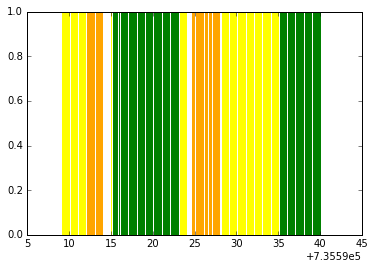

In [134]:
color_timeline(df['treeline-above'])
plt.autoscale()

In [36]:
ratdict = {rat:i for i,rat in enumerate(ratings)}

In [49]:
df2 = df.replace({'treeline-above':ratdict,
            'treeline-below':ratdict,
            'treeline-near':ratdict,}
                 ).set_index('utc')

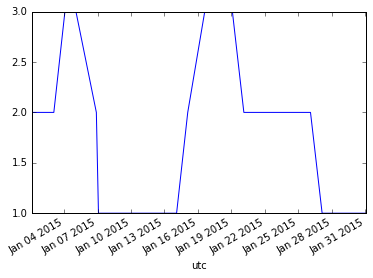

In [54]:
df2['treeline-above'].plot()